# Auto Regression Model
Auto-regression model components of a signal serially, each one conditionally to the ones already modeled. They rely on the chain rule from probability theory, given $X_1,...,X_T$ random variable, we have

\begin{align}
\forall x_1,..., x_T, P(X_1=x_1,...X_T=x_T) = P(X_1=x_1)P(X_2=x_2|X_1=x_1),...,P(X_T=x_T|X_1=x_1,...,X_{T-1}=x_{t-1})
\end{align}

Deep neural networks are a fitting class of models for such conditional densities when dealing with large dimesion signal.

Given a sequence of r.v. $X_1,...,X_T$ on $\mathbb{R}$, we can represent a conditioning event of the form
\begin{align}
X_{t(1)} = x_1,..., X_{t(N)}=x_N 
\end{align}
with 2 tensors of dimension T: Mask tensor and Value tensor.

<img src = "example_tensors.png" aligh='left'/>



# Formalize problem
In what follows, we will consider only finite distributions over ${C}$ real values. Hence we can model a conditional distribution with a mapping that maps a pair
mask / known values to a distribution for the next value of the sequence:

\begin{align}
\mathbb{f}: {\{0, 1\}}^T \times \mathbb{R}^T \to \mathbb{R}^{C}
\end{align}

where the $C outputs values can be either probabilities, or as we will prefer, logits.

This can be generalized beyond categorical distributions by mapping to
parameters of any distribution. Our Task should be estimated the $\mathbb{f}.$


# Generate Data
Given such a model and a sampling procedure sample, then generative process for a full sequence

\begin{align}
x_1 &\leftarrow sample(f(\{\})) \\
x_2 &\leftarrow sample(f(\{X_1= x_1\})) \\
x_3 &\leftarrow sample(f(\{X_1=x_1, X_2=x_2\})) \\
    &... \\
x_T &\leftarrow sample(f(\{X_1=x_1, X_2=x_2,...,X_{T-1}=x_{T-1}\})) 
\end{align}

<img src = "generate_process.png" aligh='left'/>

# Training Process

## Input Data

In practice, for each batch, we sample a position to predict for each sample at random,
from which we build the masks, conditioning values, and target values.

The training can be done with mini-batches which
are generated as follows:
We start from a tensor of training sequences,
and pick the position of the value to predict at
random in each, depicted with the red circles.
We create a mask and a value tensor with 1s and
values in each sequence up to the value before
the value to predict and zeros after.
We create the target vector with the values to
predict for each sequence

<img src = "feeding_data.png" aligh='left'/>

## Loss function MLE

With a finite distribution and the output values interpreted as logits, training consists of
maximizing the likelihood of the training samples, hence minimizing

\begin{align}
\mathcal{L\mathbb(f)} & = - \sum_{n}\sum_{t} log  \hat{p}(X_t=x_{n,t}|X_1=x_{n,1},...,X_{t-1}=x_{n,t-1}) \\
& = \sum_{n}\sum_{t} \mathcal{l}(\mathbb{f}((1,...,1,0,...,0), (x_{n,1},...x_{n,t-1},0,...0)),x_{n,t})
\end{align}

where $\mathcal{l}$ is the cross-entropy.

In [1]:

import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import seaborn as sns
from src.ar_model import LeNetMNIST
from src.ar_inference  import *
from src.util import *
from src.get_data import get_mnist_data
from src.ar_train import train_ar
%matplotlib inline

In [2]:
train_input, testing_input, _, _ = get_mnist_data()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mu, std = train_input.mean(), train_input.std()

In [4]:
#model = train_ar(model, 0.075, train_input, 256, 2)

PATH = "model/auto_regression"
model = LeNetMNIST(nb_classes=256)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Example Train the model

In [5]:
model.train()
train_ar(model, 0.005, train_input, 512, 5)


for 0 epo the loss: 0.1823340686969459
for 1 epo the loss: 0.18229109223466367
for 2 epo the loss: 0.18046462471829727
for 3 epo the loss: 0.18413069797679782
for 4 epo the loss: 0.18448636878747493


LeNetMNIST(
  (features): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=5184, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
  )
)

# Generate data without prior information

In [6]:
model.eval()

LeNetMNIST(
  (features): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=5184, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
  )
)

In [7]:
generate_data = inference(model,32, train_input.shape[1:], mu, std)


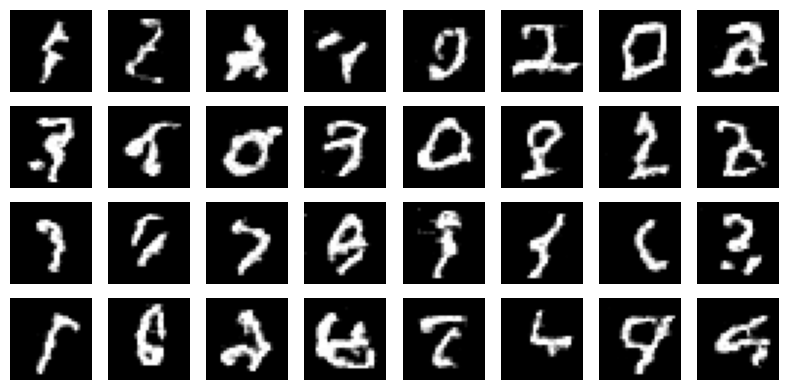

In [8]:

plot_inference(generate_data, 4, 8)

# Generate Data wiht prior, 
The prior from the testing data and make the bottom half of image as gray. 

In [9]:
image_id, prior_nrow = 1109, 14
prior = testing_input[image_id,:,:prior_nrow,:]

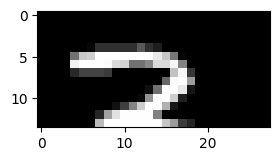

In [10]:
plot_prior(prior)

In [11]:
generate_data_with_prior = inference_with_prior(model,32, train_input.shape[1:], mu, std, prior)

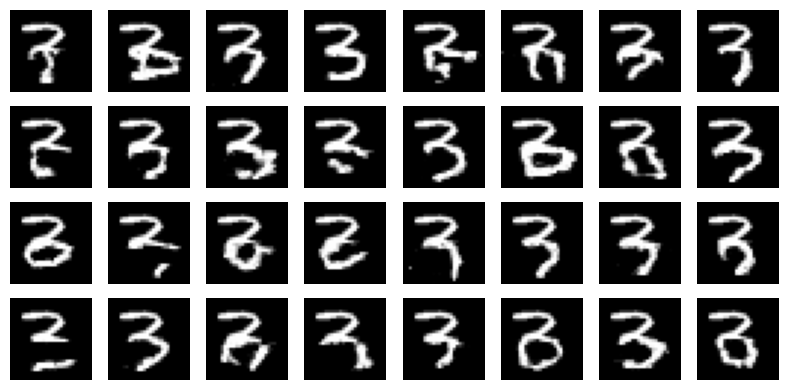

In [12]:
plot_inference(generate_data_with_prior, 4, 8)

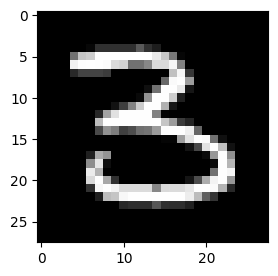

In [13]:
img = testing_input[image_id].reshape(28,28)
fig = plt.figure(figsize=(3, 3))
# And displaying the image
plt.imshow(img, cmap="gray")

In [14]:
# save model
#PATH = "model/auto_regression"
#torch.save(model.state_dict(), PATH)
## Ref: https://fleuret.org/dlc/